In [17]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama, OllamaEmbeddings
from dotenv import load_dotenv

In [18]:
load_dotenv()

llm = ChatOllama(
    model="llama3",
    temperature=0
)

In [19]:
docs = [
    "LangChain is a framework for working with large language models.",
    "Langgraph is a framework that allows you to build workflows in the form of state graphs.",
    "Retrieval-Augmented Generation (RAG) combines Context retrieval and response generation.",
    "FAISS is a library for finding the closest vectors in embeddings."
]

In [20]:
#Division into chunks;
splitter = RecursiveCharacterTextSplitter(chunk_size = 100, chunk_overlap = 10)
splits = splitter.create_documents(docs)

#Index in the vector database;
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(splits, embedding=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k":2})

In [21]:
class State(TypedDict):
    question: str
    context: str
    answer: str
    pass_eval: str

In [22]:
def retrieval(state: State)-> State:
    docs = retriever.invoke(state['question'])
    context = "\\n".join([d.page_content for d in docs])
    return {"context": context}

In [23]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an assistant who locates information in documents. Respond only based on CONTEXT:\\n{context}"),
    ("user", "{question}")
])

def generation(state: State) -> State:
    response = (prompt | llm).invoke({
        "context": state["context"],
        "question": state["question"]
    })
    return {"answer": response.content}

In [24]:
eval_prompt = ChatPromptTemplate.from_messages([
    ("system", "Evaluate answer."),
    ("user", "Question: {question}\\nAnswer: {answer}\\nDoes the answer contain a needed information? Answer only 'yes' or 'no'.")
])

def eval_node(state: State) -> State:
    response = (eval_prompt | llm).invoke({
        "question": state["question"],
        "answer": state["answer"]
    })
    result = response.content.strip().lower().startswith("yes")
    return {"pass_eval": result}

In [25]:
def finish(state: State) -> State:
    if state["pass_eval"]:
        print(f"✅ Answer approved: {state['answer']}")
    else:
        print("❌ The answer does not contain a solution.")
    return state

In [26]:
graph = StateGraph(State)

graph.add_node("retrieval", retrieval)
graph.add_node("generation", generation)
graph.add_node("eval", eval_node)
graph.add_node("finish", finish)

graph.set_entry_point("retrieval")
graph.add_edge("retrieval", "generation")
graph.add_edge("generation", "eval")

def check_eval(state: State):
    return "finish" if state["pass_eval"] else "generation"

graph.add_conditional_edges("eval", check_eval, ["finish", "generation"])
graph.add_edge("finish", END)

app = graph.compile(debug=True)

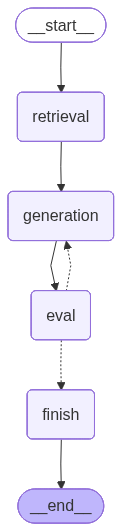

In [27]:
from IPython.display import Image, display

# Assuming 'app' is your compiled StateGraph
display(Image(app.get_graph().draw_mermaid_png()))

In [29]:
app.invoke({"question": "What is a LangGraph?"})

[values] {'question': 'What is a LangGraph?'}
[updates] {'retrieval': {'context': 'Langgraph is a framework that allows you to build workflows in the form of state graphs.\\nLangChain is a framework for working with large language models.'}}
[values] {'question': 'What is a LangGraph?', 'context': 'Langgraph is a framework that allows you to build workflows in the form of state graphs.\\nLangChain is a framework for working with large language models.'}
[updates] {'generation': {'answer': 'According to the context, LangGraph is a framework that allows you to build workflows in the form of state graphs.'}}
[values] {'question': 'What is a LangGraph?', 'context': 'Langgraph is a framework that allows you to build workflows in the form of state graphs.\\nLangChain is a framework for working with large language models.', 'answer': 'According to the context, LangGraph is a framework that allows you to build workflows in the form of state graphs.'}
[updates] {'eval': {'pass_eval': True}}
[va

{'question': 'What is a LangGraph?',
 'context': 'Langgraph is a framework that allows you to build workflows in the form of state graphs.\\nLangChain is a framework for working with large language models.',
 'answer': 'According to the context, LangGraph is a framework that allows you to build workflows in the form of state graphs.',
 'pass_eval': True}